In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from torchsummary import summary

In [5]:
from scipy.optimize import curve_fit

In [34]:
from cnn_aux import files_list_npy_csv, select_image_and_lbl, get_energy, mean_rms
from cnn_models import GIDataset, CNN_basic, evaluate_cnn
from cnn_plot import histoplot, plot_images,scatter_xyz, scatter_xyze

In [36]:
#from pymono.aux_func import files_list_npy_csv, select_image_and_lbl
#from pymono.plt_funcs import plot_images

In [7]:
from pymono.mono_dl import mono_data_loader
from pymono.plt_funcs import plot_images_ds, plot_loss, plotxyz
from pymono.cnn_eval import train_cnn
from pymono.cnn_fit import fit_tdeltas, plotfxyz
from cnn_plot import plotxyz_twoc

In [9]:
#from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [16]:
#from pymono.aux_func import select_image_and_lbl, get_energy, mean_rms

In [8]:
#from pymono.plt_funcs import plot_images, plot_energies2, plot_images_ds, plot_loss, plotxyz, histoplot

In [9]:
#from pymono.cnn_func import CNN_basic

In [10]:
#from pymono.cnn_eval import train_cnn, evaluate_cnn

In [11]:
#from pymono.cnn_fit import fit_coord, fit_tdeltas, plotfxyz

In [ ]:
#from pymono.aux_func import select_image_files, select_image_and_metadata, energy
#from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
#from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [ ]:
#from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
#from pymono.plt_funcs import  plot_true_predicted, plotxyz, plotxyze, plot_h3d, plot_energies2, plot_loss
#from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [ ]:
#from pymono.cnn_plots import plot_images2

In [ ]:
#from pymono.cnn_func import single_run, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [ ]:
#from pymono.plt_funcs import  plot_energies2, histoplot, plotxyz, plot_dataset

In [ ]:
#from pymono.cnn_plots import plot2c_z, plot_images_and_labels, plot_images_and_positions

In [ ]:
#from pymono.cnn_eval import evaluate_cnn, evaluate_2c_cnn, cnn_xeval, single_run, train_cnn

In [ ]:
#from pymono.cnn_func import ResNet10

In [ ]:
#from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [ ]:
#from pymono.cnn_func import CNN_basic

In [ ]:
#from pymono.cnn_fit import fit_coord, fit_tdeltas, plotfxyz

In [ ]:
#from pymono.xdataset import PDataset

In [ ]:
#from pymono.cnn_aux import get_file_names_format1, get_image_file_data, get_img_file_metadata

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [9]:
data_dir = Path(os.environ['DATA'])
imgdir = os.path.join(data_dir,"G4Prods/crystalGI", "BGOH1")
g4dir = os.path.join(data_dir,"G4Prods/crystalGI", "G4BGOH1")
fsp = "sensor_positions.csv"

# Setup

- BGO crystal (10k phot/MeV)
- gammas interact uniformly in x,y and according to X0 in z

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 0MHzDC 
- PTFE wrapping (all sides)
- LUT model
- crystalGI simulation


### read dataframe with sensor positions

In [10]:
dfs = pd.read_csv(f"{g4dir}/{fsp}", header=0)
dfs.head(10)

,sensor_id,sensor_x,sensor_y,sensor_z
0,0,-21,-21,11.7
1,1,-21,-15,11.7
2,2,-21,-9,11.7
3,3,-21,-3,11.7
4,4,-21,3,11.7
5,5,-21,9,11.7
6,6,-21,15,11.7
7,7,-21,21,11.7
8,8,-15,-21,11.7
9,9,-15,-15,11.7


### select image and metadata for a given file number

In [11]:
imgs, mdata = select_image_and_lbl(imgdir, 0)

Selected files: img = images_0.npy, metdata = metadata_0.csv


In [12]:
mdata.head(10)

,event,etot,ntrk,t1,x1,y1,z1,e1,t2,x2,y2,z2,e2
0,0,511.0,2,20.3,20.2,-6.4,-5.0,297.7,24.4,19.0,-6.5,-5.5,213.3
1,1,511.0,2,11.1,-10.1,-19.9,-7.8,4.7,62.8,-9.5,-17.9,7.6,506.3
2,2,511.0,1,52.8,8.6,-21.6,4.7,511.0,52.8,8.6,-21.6,4.7,511.0
3,3,511.0,2,48.5,1.9,-20.9,3.5,69.4,50.0,2.0,-20.7,3.8,441.6
4,4,511.0,2,40.8,9.2,-4.0,1.1,332.2,44.9,8.9,-4.6,0.1,178.8
5,5,511.0,1,37.3,0.6,11.5,0.1,511.0,37.3,0.6,11.5,0.1,511.0
6,6,511.0,1,5.5,7.3,1.1,-9.4,511.0,5.5,7.3,1.1,-9.4,511.0
7,8,511.0,1,3.2,-17.6,-23.4,-10.1,511.0,3.2,-17.6,-23.4,-10.1,511.0
8,9,511.0,2,44.5,21.4,19.2,2.2,338.7,49.7,20.9,19.2,0.7,172.3
9,10,511.0,1,10.3,-14.2,1.7,-8.0,511.0,10.3,-14.2,1.7,-8.0,511.0


In [13]:
m2 = mdata.drop(["event", "etot", "ntrk", "t1", "t2"], axis=1)
m2.head(10)

,x1,y1,z1,e1,x2,y2,z2,e2
0,20.2,-6.4,-5.0,297.7,19.0,-6.5,-5.5,213.3
1,-10.1,-19.9,-7.8,4.7,-9.5,-17.9,7.6,506.3
2,8.6,-21.6,4.7,511.0,8.6,-21.6,4.7,511.0
3,1.9,-20.9,3.5,69.4,2.0,-20.7,3.8,441.6
4,9.2,-4.0,1.1,332.2,8.9,-4.6,0.1,178.8
5,0.6,11.5,0.1,511.0,0.6,11.5,0.1,511.0
6,7.3,1.1,-9.4,511.0,7.3,1.1,-9.4,511.0
7,-17.6,-23.4,-10.1,511.0,-17.6,-23.4,-10.1,511.0
8,21.4,19.2,2.2,338.7,20.9,19.2,0.7,172.3
9,-14.2,1.7,-8.0,511.0,-14.2,1.7,-8.0,511.0


In [14]:
m2o = m2[['x1', 'y1', 'z1','x2','y2','z2','e1','e2']]
m2o.head(10)

,x1,y1,z1,x2,y2,z2,e1,e2
0,20.2,-6.4,-5.0,19.0,-6.5,-5.5,297.7,213.3
1,-10.1,-19.9,-7.8,-9.5,-17.9,7.6,4.7,506.3
2,8.6,-21.6,4.7,8.6,-21.6,4.7,511.0,511.0
3,1.9,-20.9,3.5,2.0,-20.7,3.8,69.4,441.6
4,9.2,-4.0,1.1,8.9,-4.6,0.1,332.2,178.8
5,0.6,11.5,0.1,0.6,11.5,0.1,511.0,511.0
6,7.3,1.1,-9.4,7.3,1.1,-9.4,511.0,511.0
7,-17.6,-23.4,-10.1,-17.6,-23.4,-10.1,511.0,511.0
8,21.4,19.2,2.2,20.9,19.2,0.7,338.7,172.3
9,-14.2,1.7,-8.0,-14.2,1.7,-8.0,511.0,511.0


In [15]:
mdata.drop(["event", "etot", "ntrk", "t1", "t2","e1", "e2"], axis=1)

,x1,y1,z1,x2,y2,z2
0,20.2,-6.4,-5.0,19.0,-6.5,-5.5
1,-10.1,-19.9,-7.8,-9.5,-17.9,7.6
2,8.6,-21.6,4.7,8.6,-21.6,4.7
3,1.9,-20.9,3.5,2.0,-20.7,3.8
4,9.2,-4.0,1.1,8.9,-4.6,0.1
...,...,...,...,...,...,...
13305,-17.3,19.8,-10.0,-17.3,19.8,-10.0
13306,-3.5,22.1,2.4,-3.5,22.1,2.4
13307,20.8,-16.1,0.8,15.1,-17.5,5.8
13308,2.2,-4.9,-3.5,2.2,-4.9,-3.5


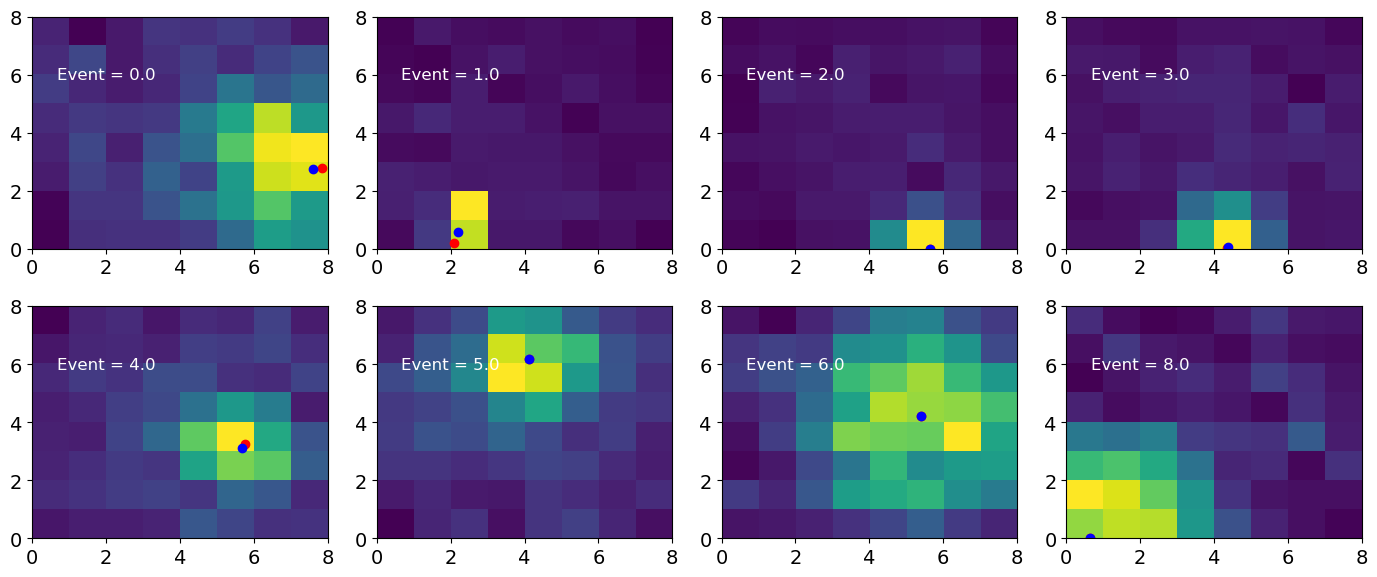

In [16]:
plot_images(imgs, mdata, dfs, range(0,8), figsize=(14, 6))

In [17]:
energy = get_energy(imgs)

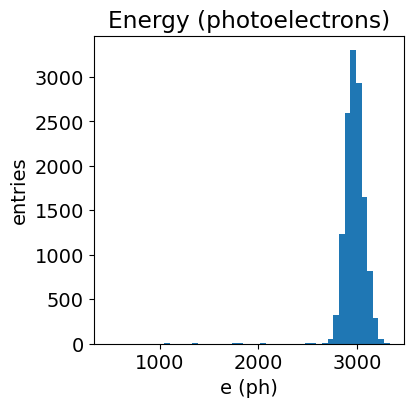

In [18]:
b, e = histoplot(energy, 'e (ph)', "entries", bins=50, figsize=(6,6),
                title="Energy (photoelectrons)")

In [19]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy[energy>2700])

print(f"mean = {mean6x6:.2f} sigma = {100*std6x6:.2f} % FWHM = {100*fwhm6x6:.2f} %")

mean = 2978.03 sigma = 3.00 % FWHM = 6.90 %


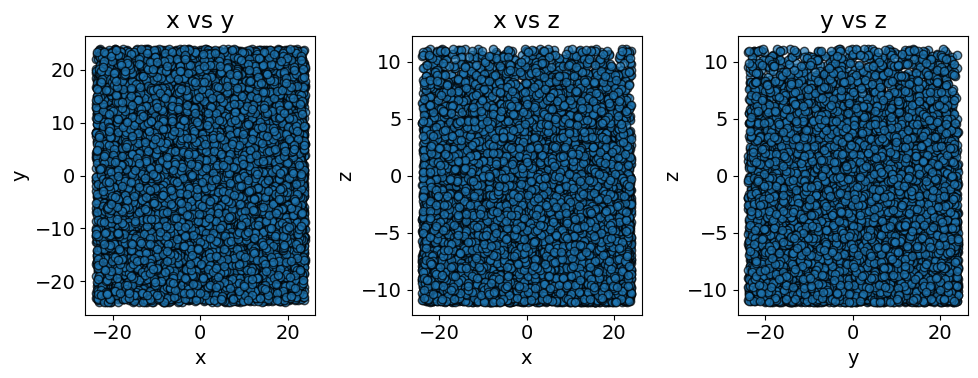

In [20]:
scatter_xyz(mdata.x1,mdata.y1,mdata.z1, figsize=(10, 4))

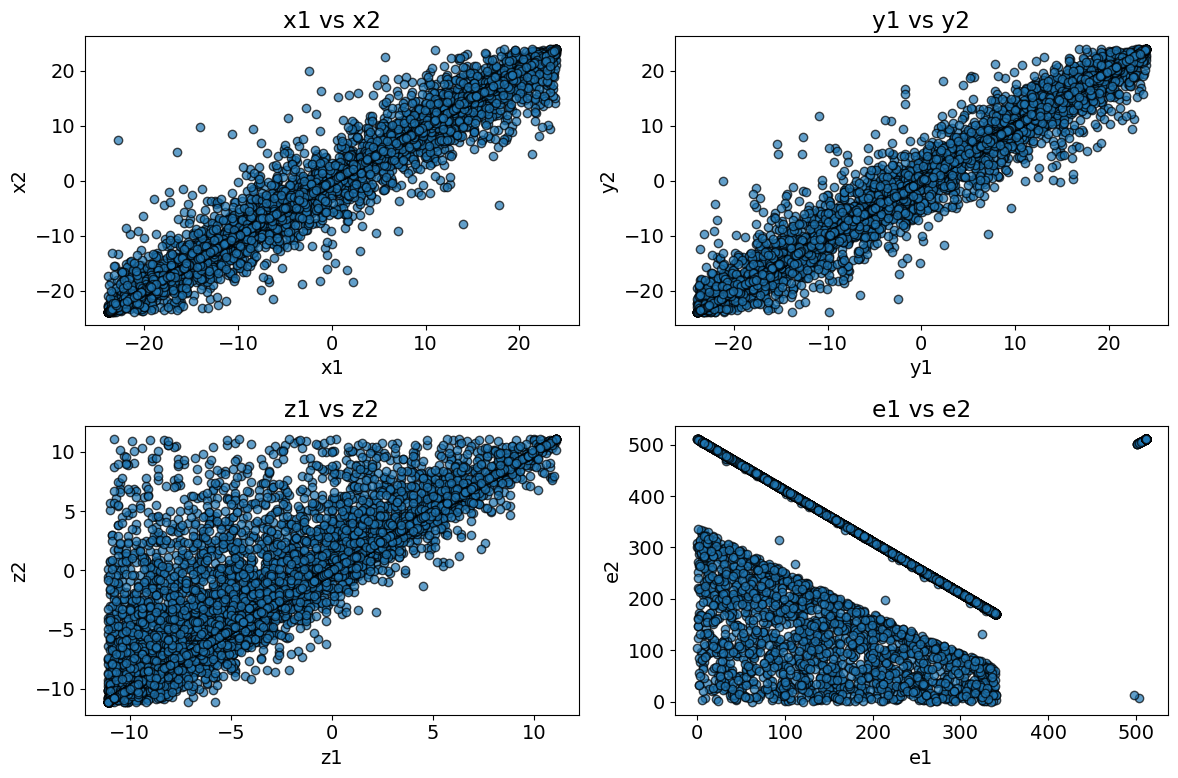

In [21]:
scatter_xyze(mdata, figsize=(12, 8))

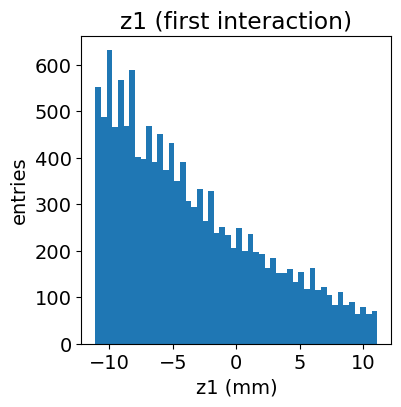

In [22]:
b, e = histoplot(mdata.z1, 'z1 (mm)', "entries", bins=50, figsize=(6,6),
                title="z1 (first interaction)")

## CNN run 1
- Use CNN_basic training only for (x,y,z), e.g, the first position of the gamma
- No normalization

In [23]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [24]:

dataset = GIDataset(imgdir, first_file, last_file,twoc=1) 


Running GIDataset with norm = False, resize=False
Loading files with indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Loading images_0.npy, metadata_0.csv
Loading images_1.npy, metadata_1.csv
Loading images_2.npy, metadata_2.csv
Loading images_3.npy, metadata_3.csv
Loading images_4.npy, metadata_4.csv
Loading images_5.npy, metadata_5.csv
Loading images_6.npy, metadata_6.csv
Loading images_7.npy, metadata_7.csv
Loading images_8.npy, metadata_8.csv
Loading images_9.npy, metadata_9.csv
Loading images_10.npy, metadata_10.csv
Loading images_11.npy, metadata_11.csv
Loading images_12.npy, metadata_12.csv
Loading images_13.npy, metadata_13.csv
Loading images_14.npy, metadata_14.csv
Loading images_15.npy, metadata_15.csv
Loading imag

In [25]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 1320177 events
 train size = 924123
 val size = 264035
 test size = 132019
 train indices = range(0, 924123)
 val indices = range(924123, 1188158)
 test indices = range(1188158, 1320177)
924123 training events (69.99993182732315%)
264035 validation events (19.999969701032512%)
132019 test events (10.000098471644332%)


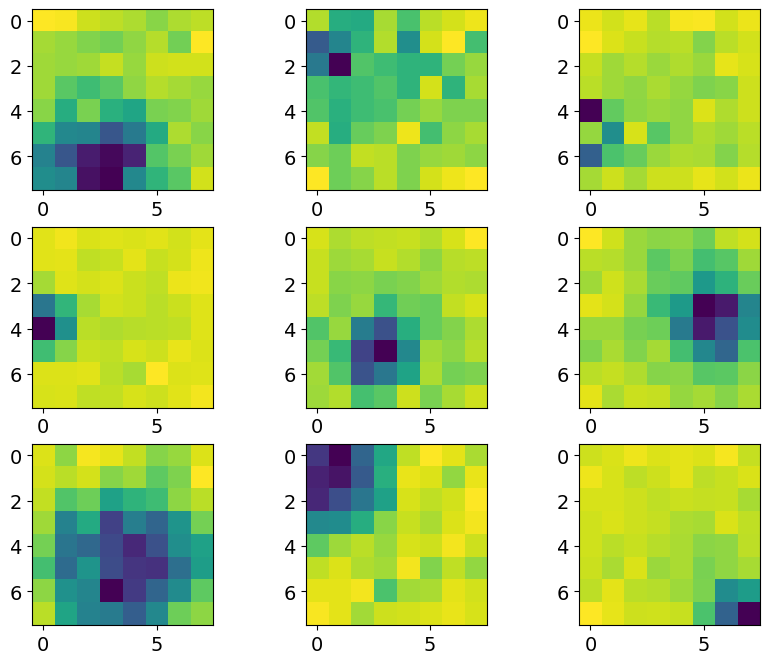

In [26]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [27]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 6])
tensor([[20., 25., 15., 24., 31., 36., 35., 36.],
        [17., 22., 24., 44., 45., 55., 47., 42.],
        [22., 42., 52., 57., 75., 68., 67., 53.],
        [31., 43., 59., 62., 97., 94., 84., 58.],
        [33., 22., 60., 90., 91., 88., 77., 68.],
        [26., 20., 54., 71., 75., 63., 59., 55.],
        [23., 22., 38., 57., 74., 68., 59., 39.],
        [16., 18., 27., 34., 42., 42., 40., 25.]])


In [28]:
model = CNN_basic(chi=128, dropout=True, dropout_fraction=0.2, twoc=1).to(device)

In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [30]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->925000 images
size of train loader  ->925 images
Evaluating with  ->265000 images
size of eval loader  ->265 images
Running for epochs ->10

EPOCH 0
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([1000, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512])
torch.Size([1000, 6])
--- EPOCH 0 AVG TRAIN LOSS: 4.618207667840494
--- EPOCH 0 AVG VAL LOSS: 3.232551928736129

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 3.5108253022786733
--- EPOCH 1 AVG VAL LOSS: 3.1992718611123427

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 3.3039459589365365
--- EPOCH 2 AVG VAL LOSS: 2.9254380122670587

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 3.186979026278934
--- EPOCH 3 AVG VAL LOSS: 2.8664093723836936

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 3.1091941735551165
--- EPOCH 4 AVG VAL LOSS: 2.8663651686794354

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 3.0592500952127817
--- EP

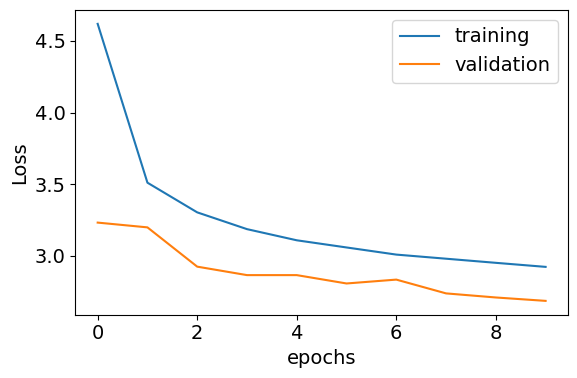

In [31]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [35]:
tdeltas = evaluate_cnn(test_loader, model, device, twoc=1)

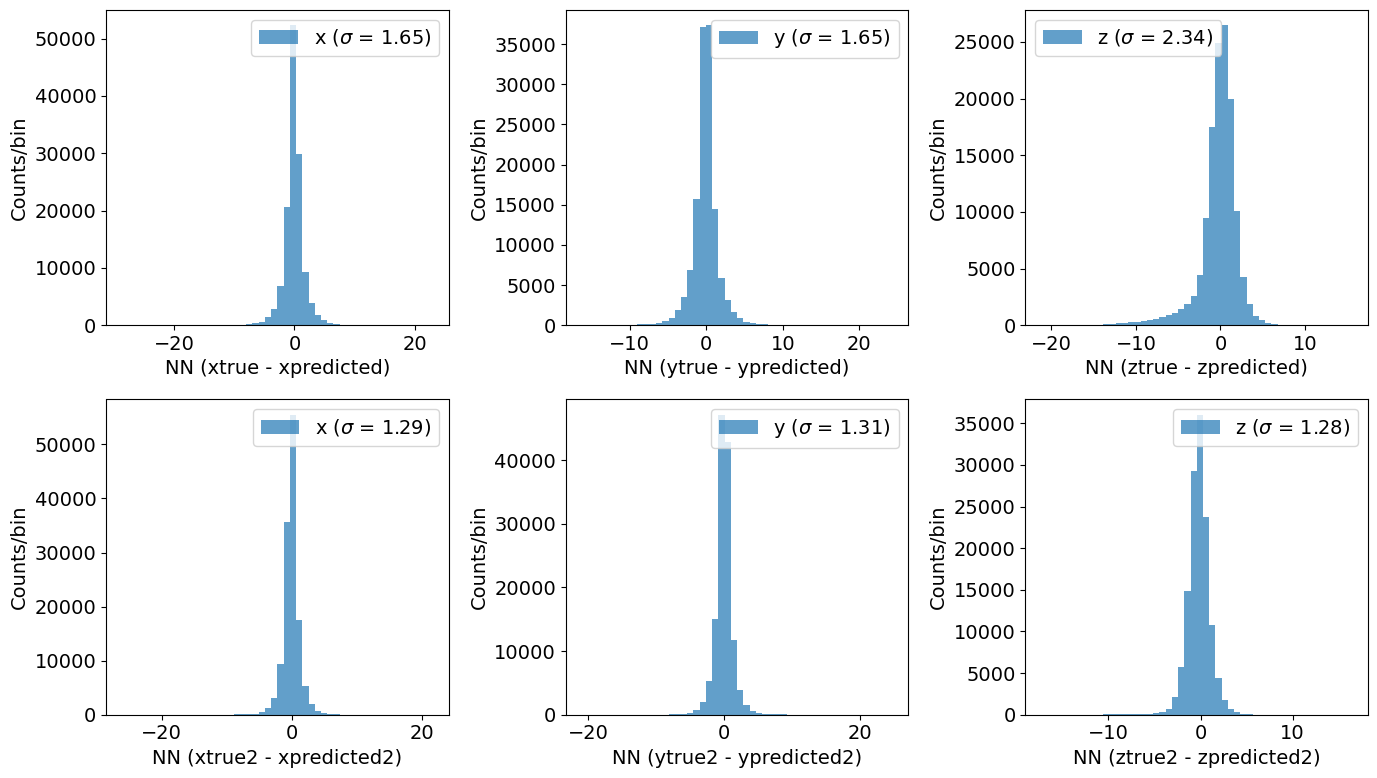

In [36]:
plotxyz_twoc(tdeltas, nbins=50)

In [37]:
f2gz, f2gx, f2gy, f2gz2, f2gx2, f2gy2 = fit_tdeltas(tdeltas, bins=100, twoc=1)

2g fit: mu1 = -1.00, sigma = 3.34, n1  =0.10
2g fit: mu2 = 0.25, sigma = 1.19, n1  =0.90
weighted error: = 1.40
2g fit: mu1 = -0.07, sigma = 1.85, n1  =0.25
2g fit: mu2 = -0.10, sigma = 0.63, n1  =0.75
weighted error: = 0.94
2g fit: mu1 = -0.04, sigma = 0.61, n1  =0.73
2g fit: mu2 = -0.16, sigma = 1.81, n1  =0.27
weighted error: = 0.93
2g fit: mu1 = -0.17, sigma = 1.36, n1  =0.38
2g fit: mu2 = -0.21, sigma = 0.70, n1  =0.62
weighted error: = 0.95
2g fit: mu1 = -0.07, sigma = 0.56, n1  =0.74
2g fit: mu2 = -0.09, sigma = 1.46, n1  =0.26
weighted error: = 0.79
2g fit: mu1 = 0.01, sigma = 0.54, n1  =0.72
2g fit: mu2 = -0.11, sigma = 1.42, n1  =0.28
weighted error: = 0.79


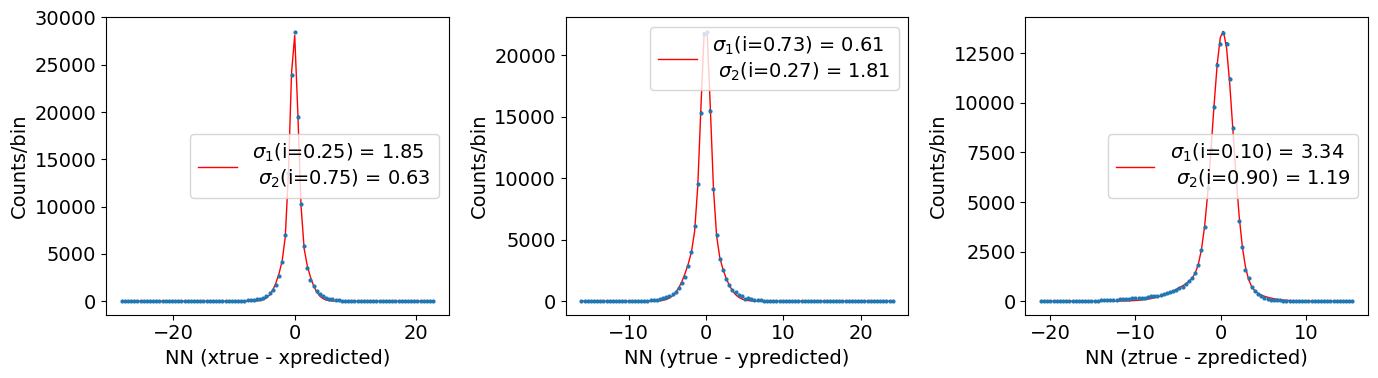

In [38]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

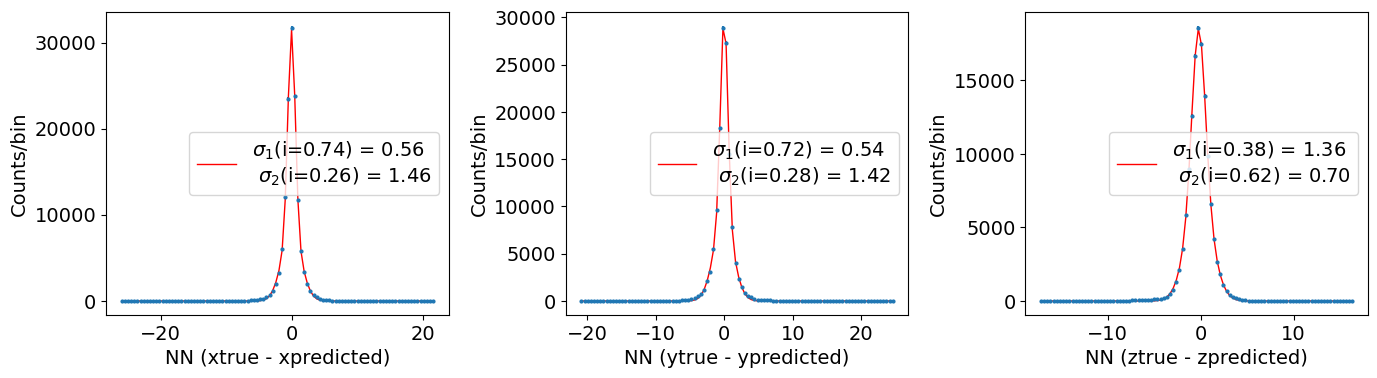

In [39]:
plotfxyz(f2gx2, f2gy2, f2gz2, figsize=(14, 4))

### Save model

In [40]:
torch.save(model.state_dict(), 'cnn_2c_bgo.pth')

### Reload model

In [44]:
modelx = CNN_basic(chi=128, dropout=True, dropout_fraction=0.2, twoc=1).to(device)

In [45]:
modelx.load_state_dict(torch.load('cnn_2c_bgo.pth'))

<All keys matched successfully>

In [46]:
tdeltasx = evaluate_cnn(test_loader, modelx, device, twoc=1)

input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([1000, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512])
torch.Size([1000, 6])


In [47]:
xf2gz, xf2gx, xf2gy, xf2gz2, xf2gx2, xf2gy2 = fit_tdeltas(tdeltasx, bins=100, twoc=1)

2g fit: mu1 = -1.00, sigma = 3.34, n1  =0.10
2g fit: mu2 = 0.25, sigma = 1.19, n1  =0.90
weighted error: = 1.40
2g fit: mu1 = -0.07, sigma = 1.85, n1  =0.25
2g fit: mu2 = -0.10, sigma = 0.63, n1  =0.75
weighted error: = 0.94
2g fit: mu1 = -0.04, sigma = 0.61, n1  =0.73
2g fit: mu2 = -0.16, sigma = 1.81, n1  =0.27
weighted error: = 0.93
2g fit: mu1 = -0.17, sigma = 1.36, n1  =0.38
2g fit: mu2 = -0.21, sigma = 0.70, n1  =0.62
weighted error: = 0.95
2g fit: mu1 = -0.07, sigma = 0.56, n1  =0.74
2g fit: mu2 = -0.09, sigma = 1.46, n1  =0.26
weighted error: = 0.79
2g fit: mu1 = 0.01, sigma = 0.54, n1  =0.72
2g fit: mu2 = -0.11, sigma = 1.42, n1  =0.28
weighted error: = 0.79


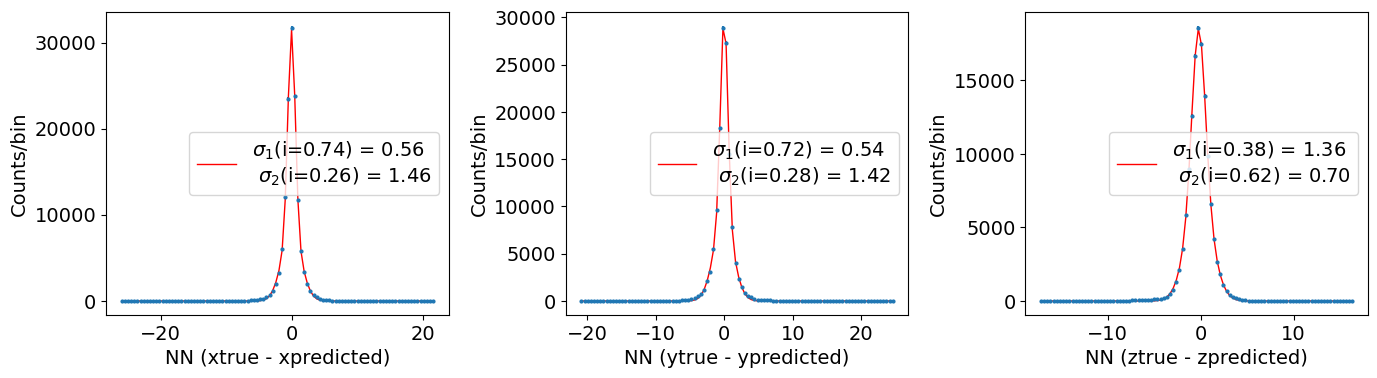

In [48]:
plotfxyz(xf2gx2, xf2gy2, xf2gz2, figsize=(14, 4))